In [1]:
import pandas as pd
import numpy as np
import healpy as hp

# Import utilities and define global parameters

In [2]:
from mapXmap_utils import make_skymap, normalize_skymap, cross_cl, map2alm, alm2cl, \
    plot_corr_func, plot_Cls, plot_Dls

# set universal nside value (override; default is 512 from mapXmap_utils)
nside = 512

# GRB x GW Cross-correlation

1.0 1.0000000000000004 0.9999999999999959 1.0


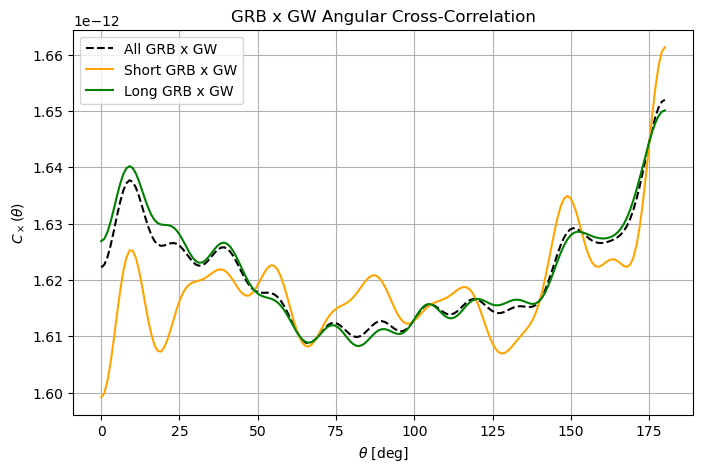

In [3]:

# load GW map data (directory for stacked GW events skymap as .npy file; made somewhere else)
GW_dir = r'GW_combined_skymap.npy'
GW_skymap = np.load(GW_dir)

# normalize GW map
GW_skymap = normalize_skymap(GW_skymap, shift_min=False)


# load GRB data
GRB_file_path = "GRB_Summary_table.txt" # just using summary data (from SWIFT/Fermi?)
df = pd.read_csv(GRB_file_path, sep='\s+', comment='#', header=None)
df.columns = [
    "GRB_Name", "Trigger", "Trigger_Time", "RA_deg", "Dec_deg", "pos_err", "T90",
    "T90_err", "T90_start", "Fluence", "Fluence_err", "Redshift", "T100",
    "GBM_located", "mjd"]

# Filter for valid burst duration and sky position error
df_filt = df[(df['T90']>=0) & (df['pos_err']>=0)]

# burt time filters for short and long, respectively
df_filt_sGRB = df_filt[df_filt['T90']<=2.0]
df_filt_lGRB = df_filt[df_filt['T90']>2.0]

# make GRB skymaps
GRB_full_sm = make_skymap(ra_deg = df_filt['RA_deg'].to_numpy(),
                          dec_deg = df_filt['Dec_deg'].to_numpy(), nside=nside)
sGRB_skymap = make_skymap(ra_deg = df_filt_sGRB['RA_deg'].to_numpy(),
                          dec_deg = df_filt_sGRB['Dec_deg'].to_numpy(), nside=nside)
lGRB_skymap = make_skymap(ra_deg = df_filt_lGRB['RA_deg'].to_numpy(),
                          dec_deg = df_filt_lGRB['Dec_deg'].to_numpy(), nside=nside)

# normalize GRB skymaps
GRB_full_sm = normalize_skymap(GRB_full_sm)
sGRB_skymap = normalize_skymap(sGRB_skymap)
lGRB_skymap = normalize_skymap(lGRB_skymap)
# normalization check:
print(GW_skymap.sum(), GRB_full_sm.sum(), sGRB_skymap.sum(), lGRB_skymap.sum())


# direct cross-cl from original maps, l≤26
GW_lmax = None
GRB_lmax = None
lmax = 26

cl_GRBxGW_drct = cross_cl(hp.alm2map(map2alm(GW_skymap, lmax=lmax), nside=nside),
                          hp.alm2map(map2alm(GRB_full_sm, lmax=lmax), nside=nside), lmax=lmax)
cl_sGRBxGW_drct = cross_cl(hp.alm2map(map2alm(GW_skymap, lmax=lmax), nside=nside),
                           hp.alm2map(map2alm(sGRB_skymap, lmax=lmax), nside=nside), lmax=lmax)
cl_lGRBxGW_drct = cross_cl(hp.alm2map(map2alm(GW_skymap, lmax=lmax), nside=nside),
                           hp.alm2map(map2alm(lGRB_skymap, lmax=lmax), nside=nside), lmax=lmax)


### plot angular cross-correlation function, C(Θ) vs Θ
plot_corr_func([cl_GRBxGW_drct, cl_sGRBxGW_drct, cl_lGRBxGW_drct],
               Cl_labels=['All GRB x GW', 'Short GRB x GW', 'Long GRB x GW'],
               colors=['black', 'orange', 'green'],
               linestyles=['--', None, None], title='GRB x GW Angular Cross-Correlation',
               ylabel=r'$C_\times(\theta)$', ylog=False)


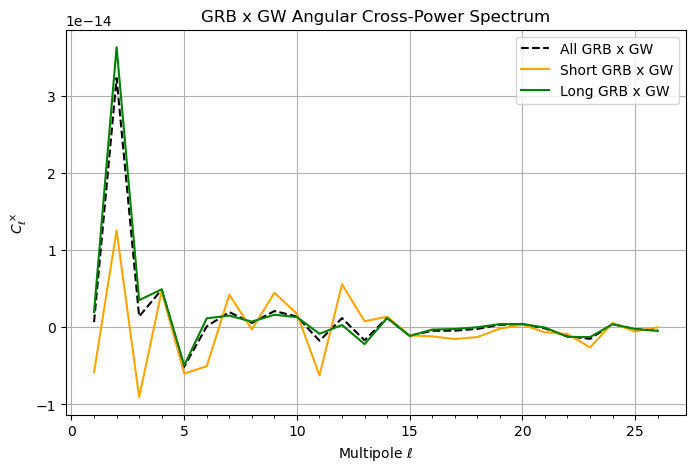

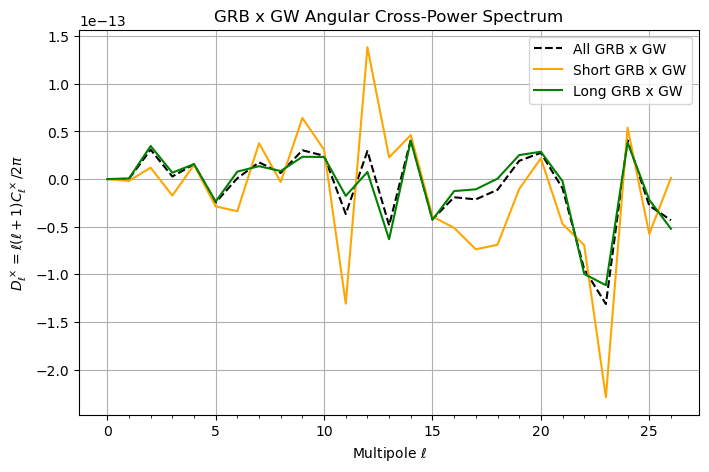

In [4]:
# plot power spectrum, C_l vs l
plot_Cls([cl_GRBxGW_drct, cl_sGRBxGW_drct, cl_lGRBxGW_drct],
         Cl_labels=['All GRB x GW', 'Short GRB x GW', 'Long GRB x GW'],
         colors=['black', 'orange', 'green'], monopole_term=False,
         linestyles=['--', None, None], title='GRB x GW Angular Cross-Power Spectrum',
         ylabel=r'$C^\times_\ell$', ylog=False)

# plot normalized power spectrum, D_l vs l
plot_Dls([cl_GRBxGW_drct, cl_sGRBxGW_drct, cl_lGRBxGW_drct],
         Cl_labels=['All GRB x GW', 'Short GRB x GW', 'Long GRB x GW'],
         colors=['black', 'orange', 'green'],
         linestyles=['--', None, None], title='GRB x GW Angular Cross-Power Spectrum',
         ylabel=r'$D^\times_\ell = \ell (\ell+1)C^\times_\ell/{2 \pi}$', ylog=False)

# ↓↓↓ other plots ↓↓↓

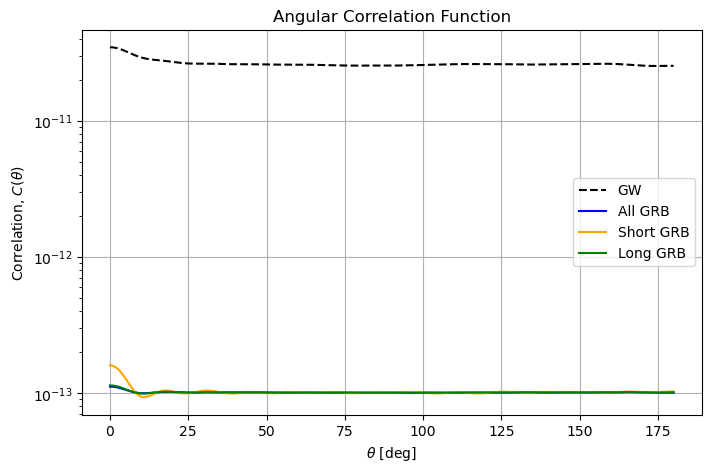

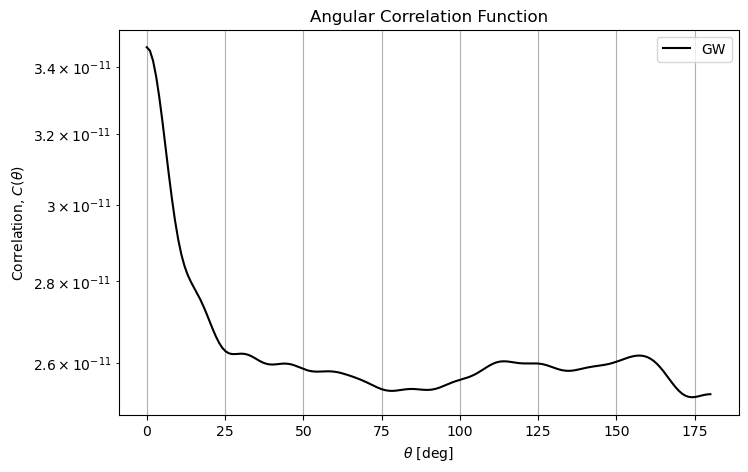

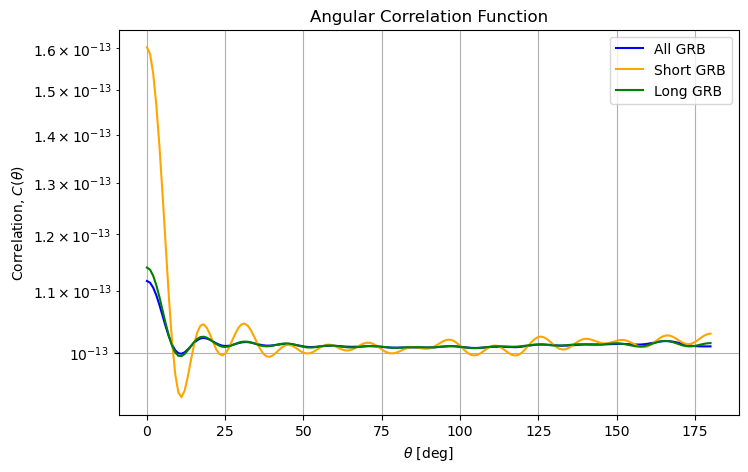

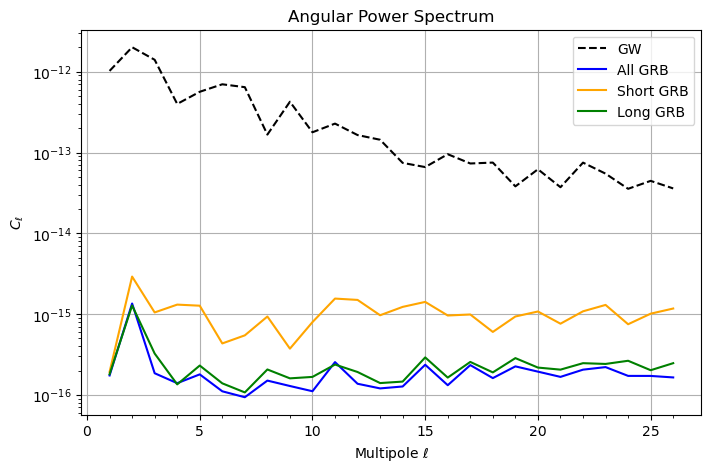

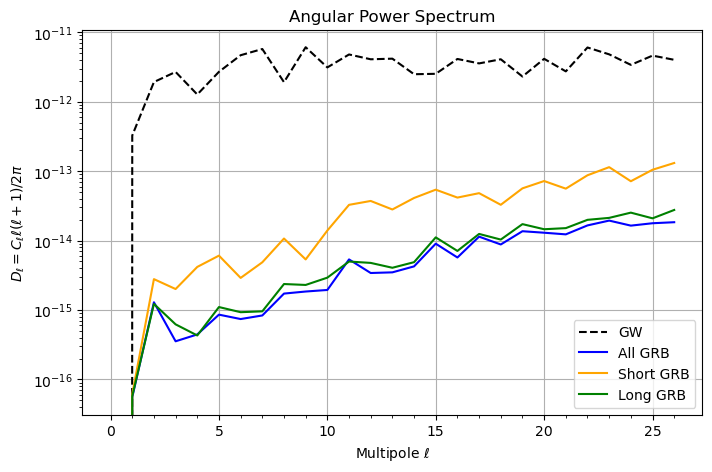

In [5]:
lmax = 26

cl_GW = alm2cl(map2alm(GW_skymap, lmax=lmax), lmax=lmax)
cl_GRB = alm2cl(map2alm(GRB_full_sm, lmax=lmax), lmax=lmax)
cl_sGRB = alm2cl(map2alm(sGRB_skymap, lmax=lmax), lmax=lmax)
cl_lGRB = alm2cl(map2alm(lGRB_skymap, lmax=lmax), lmax=lmax)

# plot angular correlation function
plot_corr_func([cl_GW, cl_GRB, cl_sGRB, cl_lGRB],
               Cl_labels=['GW', 'All GRB', 'Short GRB', 'Long GRB'],
               colors=['black', 'blue', 'orange', 'green'],
               linestyles=['--', None, None, None], title='Angular Correlation Function', ylog=True)

plot_corr_func(cl_GW, Cl_labels='GW', colors='black', title='Angular Correlation Function', ylog=True)

plot_corr_func([cl_GRB, cl_sGRB, cl_lGRB],
               Cl_labels=['All GRB', 'Short GRB', 'Long GRB'],
               colors=['blue', 'orange', 'green'], title='Angular Correlation Function', ylog=True)

# plot power spectrum
plot_Cls([cl_GW, cl_GRB, cl_sGRB, cl_lGRB],
         Cl_labels=['GW', 'All GRB', 'Short GRB', 'Long GRB'],
         colors=['black', 'blue', 'orange', 'green'],
         linestyles=['--', None, None, None], monopole_term=False,
         title='Angular Power Spectrum', ylog=True)

plot_Dls([cl_GW, cl_GRB, cl_sGRB, cl_lGRB],
         Cl_labels=['GW', 'All GRB', 'Short GRB', 'Long GRB'],
         colors=['black', 'blue', 'orange', 'green'],
         linestyles=['--', None, None, None],
         title='Angular Power Spectrum', ylog=True)

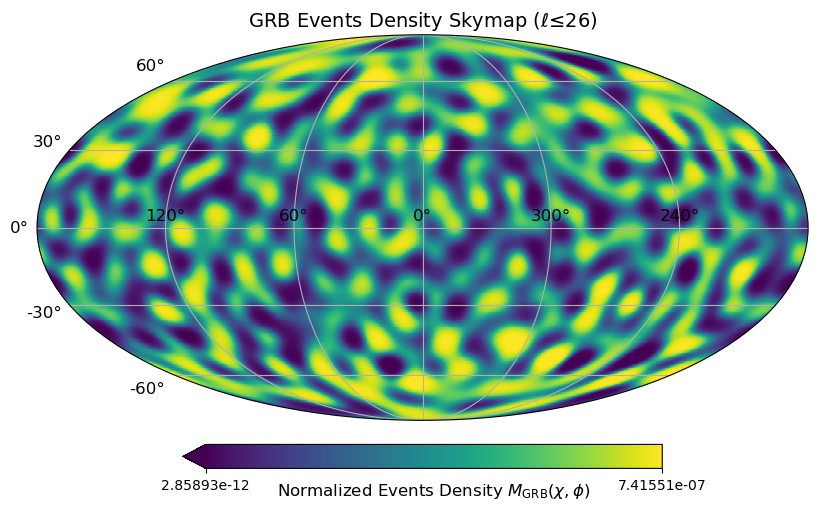

In [6]:
# creating skymaps

from mapXmap_utils import blur_map, blur_mapANDalm, plot_skymap, plot_skymap_special

plot_skymap(blur_map(GRB_full_sm, lmax=lmax, remove_monopole=False, nside=nside),
            title=f'GRB Events Density Skymap ($\ell≤{lmax}$)', norm='hist',
            unit=r'Normalized Events Density $M_\text{GRB}(\chi, \phi)$')



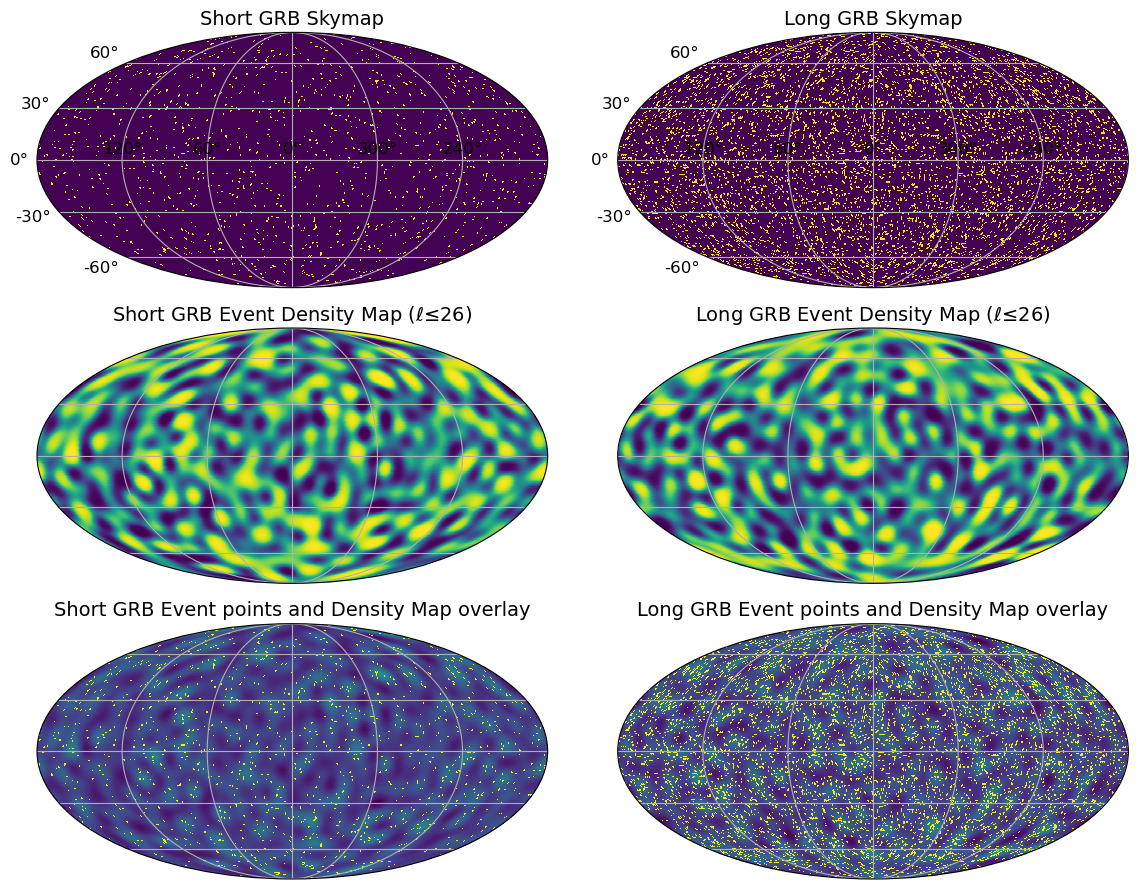

0j 0j
0.9999999999999959 0.9999999999999993 1.0 1.0000000000000002


In [7]:
from matplotlib import pyplot as plt


# GRB event (points) and desnity overlay; lower resolution (i.e., lower nside)

nside_GRB = 64
lmax_GRB = 26


# make make lower resolutoin **RAW** s/l GRB skymaps
sGRB_skymap_ = make_skymap(ra_deg = df_filt_sGRB['RA_deg'].to_numpy(),
                          dec_deg = df_filt_sGRB['Dec_deg'].to_numpy(), nside=nside_GRB)
lGRB_skymap_ = make_skymap(ra_deg = df_filt_lGRB['RA_deg'].to_numpy(),
                          dec_deg = df_filt_lGRB['Dec_deg'].to_numpy(), nside=nside_GRB)
sGRB_skymap_ = normalize_skymap(sGRB_skymap_)
lGRB_skymap_ = normalize_skymap(lGRB_skymap_)


# make "blurred skymaps", remove monopole, then normalize
sGRB_sm_lmax, alm_sGRB = blur_mapANDalm(sGRB_skymap_, lmax=lmax_GRB, remove_monopole=True)
sGRB_sm_lmax = normalize_skymap(sGRB_sm_lmax, shift_min=True)

lGRB_sm_lmax, alm_lGRB = blur_mapANDalm(lGRB_skymap_, lmax=lmax_GRB, remove_monopole=True)
lGRB_sm_lmax = normalize_skymap(lGRB_sm_lmax, shift_min=True)


# make low-res blurred skymaps for overlay plotting
sGRB_sm_lmax_lowres = blur_map(sGRB_skymap_, lmax=lmax_GRB, remove_monopole=True, nside=nside_GRB)
sGRB_sm_lmax_lowres = normalize_skymap(sGRB_sm_lmax_lowres, shift_min=True)

lGRB_sm_lmax_lowres= blur_map(lGRB_skymap_, lmax=lmax_GRB, remove_monopole=True, nside=nside_GRB)
lGRB_sm_lmax_lowres = normalize_skymap(lGRB_sm_lmax_lowres, shift_min=True)


# plot all 6 skymaps: s/l GRB raw, s/l GRB blurred, and s/l count and density overlay
fig = plt.figure(figsize=(12, 9))

hp.projview(sGRB_skymap_, fig=fig, sub=(3, 2, 1), norm='hist',
            graticule = True, graticule_labels = True,
            title='Short GRB Skymap', projection_type='mollweide', cbar=False)

hp.projview(lGRB_skymap_, fig=fig, sub=(3, 2, 2), norm='hist',
            graticule = True, graticule_labels = True,
            title='Long GRB Skymap', projection_type='mollweide', cbar=False)

hp.projview(sGRB_sm_lmax, fig=fig, sub=(3, 2, 3),
            graticule = True, graticule_labels = False, norm='hist',
            title=f'Short GRB Event Density Map ($\ell≤{lmax_GRB}$)',
            projection_type='mollweide', cbar=False)

hp.projview(lGRB_sm_lmax, fig=fig, sub=(3, 2, 4),
            graticule = True, graticule_labels = False, norm='hist',
            title=f'Long GRB Event Density Map ($\ell≤{lmax_GRB}$)',
            projection_type='mollweide', cbar=False)

hp.projview(normalize_skymap(300*sGRB_skymap_ + sGRB_sm_lmax_lowres), fig=fig, sub=(3, 2, 5),
            graticule = True, norm='hist',
            title='Short GRB Event points and Density Map overlay',
            projection_type='mollweide', cbar=False)

hp.projview(normalize_skymap(500*lGRB_skymap_ + lGRB_sm_lmax_lowres), fig=fig, sub=(3, 2, 6),
            graticule = True, norm='hist',
            title='Long GRB Event points and Density Map overlay',
            projection_type='mollweide', cbar=False)


plt.tight_layout()
plt.show()

print(alm_sGRB[0], alm_lGRB[0])
print(sGRB_skymap.sum(), sGRB_sm_lmax.sum(), lGRB_skymap.sum(), lGRB_sm_lmax.sum())